In [2]:
import json
import os
import numpy as np
import math
from typing import Dict, List, Tuple

from datetime import timedelta
from config import *
from utils import *
from main import *

import plotly.graph_objects as go

data = test_umass()
print(len(data["Microwave [kW]"]))
ctx_info = ContextAccessor({
        "min_of_day#NUM" : {
            "range" : (0, 24*60),
            "interval" : 20,
        },
        "humidity#NUM" : {
            "range" : (0., 1.0),
            "interval" : 0.1,
        }
    })
on_rate = np.full(ctx_info.get_ctx_space_shape(), -0.1)

for dis in data["Washing_Machine [kW]"]:
    on_rate[dis["coor"]] = dis["distribution"][1] / (dis["distribution"][0] + dis["distribution"][1])

fig = go.Figure(data=go.Heatmap(z=np.transpose(on_rate)))
fig.show()

DEBUG:root:The number of device events from processed file: {'Microwave [kW]': 5013, 'Washing_Machine [kW]': 589}
DEBUG:root:The number of context events from processed file: {'apparentTemperature#NUM': 8743, 'humidity#NUM': 7669, 'summary#CAT': 1892}
528


In [3]:
on_rate = np.full(ctx_info.get_ctx_space_shape(), -0.1)
for dis in data["Microwave [kW]"]:
    on_rate[dis["coor"]] = dis["distribution"][1] / (dis["distribution"][0] + dis["distribution"][1])
print(data["Microwave [kW]"][0]["distribution"])

fig = go.Figure(data=go.Heatmap(z=np.transpose(on_rate)))
fig.show()



[198.  15.]


G:matplotlib.font_manager:findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05
[0.54301754 0.45698246]
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 7.698636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Thaana' (NotoSansT

[Text(167.4, 199.32, 'X[1] <= 3.5\nmse = 0.008\nsamples = 720\nvalue = 0.009'),
 Text(83.7, 163.07999999999998, 'X[0] <= 29.5\nmse = 0.007\nsamples = 288\nvalue = -0.046'),
 Text(41.85, 126.83999999999999, 'X[0] <= 26.5\nmse = 0.0\nsamples = 120\nvalue = -0.097'),
 Text(20.925, 90.6, 'X[0] <= 2.5\nmse = 0.0\nsamples = 108\nvalue = -0.1'),
 Text(10.4625, 54.359999999999985, 'X[1] <= 0.5\nmse = 0.0\nsamples = 12\nvalue = -0.1'),
 Text(5.23125, 18.119999999999976, 'mse = -0.0\nsamples = 3\nvalue = -0.1'),
 Text(15.693750000000001, 18.119999999999976, 'mse = 0.0\nsamples = 9\nvalue = -0.1'),
 Text(31.387500000000003, 54.359999999999985, 'X[1] <= 0.5\nmse = 0.0\nsamples = 96\nvalue = -0.1'),
 Text(26.15625, 18.119999999999976, 'mse = 0.0\nsamples = 24\nvalue = -0.1'),
 Text(36.61875, 18.119999999999976, 'mse = 0.0\nsamples = 72\nvalue = -0.1'),
 Text(62.775000000000006, 90.6, 'X[1] <= 2.5\nmse = 0.003\nsamples = 12\nvalue = -0.07'),
 Text(52.3125, 54.359999999999985, 'X[0] <= 27.5\nmse = 0.

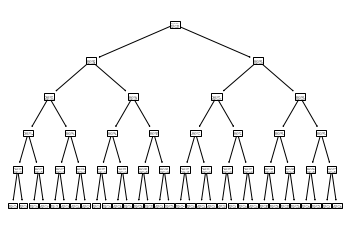

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
reg_x = []
reg_y = []
for i in range(ctx_info.get_ctx_space_shape()[0]):
    for j in range(ctx_info.get_ctx_space_shape()[1]):
        reg_x.append([i,j])
        reg_y.append(on_rate[i,j])
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit(reg_x, reg_y)
print(regressor.feature_importances_)
# tree.plot_tree(regressor)

on_rate_group = np.full(ctx_info.get_ctx_space_shape(), 0.)
for i in range(ctx_info.get_ctx_space_shape()[0]):
    for j in range(ctx_info.get_ctx_space_shape()[1]):
        on_rate_group[i,j] = regressor.predict([[i,j]])

fig = go.Figure(data=go.Heatmap(z=np.transpose(on_rate_group)))
fig.show()

In [19]:
data = test_umass(test_project="HomeD/2016")
on_rate = np.full(ctx_info.get_ctx_space_shape(), -0.1)
for dis in data["Microwave [kW]"]:
    on_rate[dis["coor"]] = dis["distribution"][1] / (dis["distribution"][0] + dis["distribution"][1])


fig = go.Figure(data=go.Heatmap(z=np.transpose(on_rate)))
fig.show()

DEBUG:root:The number of device events from processed file: {'Microwave [kW]': 1475, 'WashingMachine [kW]': 289}
DEBUG:root:The number of context events from processed file: {'apparentTemperature#NUM': 8764, 'humidity#NUM': 7703, 'summary#CAT': 2578}


In [20]:
data = test_umass(test_project="HomeA/2016")
on_rate = np.full(ctx_info.get_ctx_space_shape(), -0.1)
for dis in data["Microwave [kW]"]:
    on_rate[dis["coor"]] = dis["distribution"][1] / (dis["distribution"][0] + dis["distribution"][1])


fig = go.Figure(data=go.Heatmap(z=np.transpose(on_rate)))
fig.show()

DEBUG:root:The number of device events from processed file: {'Microwave [kW]': 1665}
DEBUG:root:The number of context events from processed file: {'apparentTemperature#NUM': 8738, 'humidity#NUM': 7642, 'summary#CAT': 2669}


In [30]:
from sklearn.neighbors import KDTree, BallTree

def find_set(uf, a):
    if uf[a] != a:
        uf[a] = find_set(uf, uf[a])
    return uf[a]

def union_set(uf, a, b):
    if find_set(uf, a) != find_set(uf, b):
        uf[find_set(uf, a)] = uf[b]

print(len(unit_of_int))
tree = KDTree(unit_of_int, leaf_size=5)   
clss = [x for x in range(len(unit_of_int))]  

dist, ind = tree.query(unit_of_int, k=4, sort_results=True)  
for idx, unit in enumerate(unit_of_int):
    prob_unit = final_space[unit] / sum(final_space[unit])
    d_i = dist[idx]
    ind_i = ind[idx]
    for i in range(4):
        if d_i[i] > 1:
            continue
        cell = unit_of_int[ind_i[i]]
        prob_ngbr = final_space[cell] / sum(final_space[cell])
        if np.linalg.norm(prob_unit - prob_ngbr) < 0.05:
            union_set(clss, idx, ind_i[i])
# print(clss)
core = []
u = np.unique([find_set(clss, i) for i in range(len(clss))])
print(u)
a = np.full(space_shape, u[0]-1)
for i, unit in enumerate(unit_of_int):
    a[unit] = find_set(clss, i)

fig = go.Figure(data=go.Heatmap(z=a))
fig.show()

528
[  1  73 117 134 138 140 168 187 209 211 212 246 259 261 296 303 320 323
 337 341 350 355 356 366 367 387 400 401 402 404 409 414 417 425 426 427
 432 448 449 461 462 463 464 465 466 479 480 481 487 489 497 513 514 519
 521 525 527]


In [29]:

time_delta = 20
d_time_delta = timedelta(minutes=10)
humidity_delta = 0.1
on_state = [[],[]]
off_state = [[],[]]
space_shape = (math.ceil(1.0/humidity_delta), math.ceil(24*60/time_delta))
final_space = np.zeros([space_shape[0], space_shape[1], 2])
data_x = []
data_y = []
min_obs = 10
unit_of_int = []
def process_snapshot(cur_time, ctx_snapshot, d_state):
    cell_idx = (int(ctx_snapshot['humidity#NUM']/humidity_delta), int(ctx_snapshot['min_of_day#NUM']/time_delta))

    if d_state == "on":
        final_space[cell_idx[0], cell_idx[1], 0] += 1
    else:
        final_space[cell_idx[0], cell_idx[1], 1] += 1
    if final_space[cell_idx[0], cell_idx[1], 1] + final_space[cell_idx[0], cell_idx[1], 0] == min_obs:
        unit_of_int.append(cell_idx)
    data_x.append([ctx_snapshot['min_of_day#NUM'], ctx_snapshot['humidity#NUM']])
    data_y.append(0 if d_state=="on" else 1)

def tag_device(ctx_evts, device_evts):
    for d, d_evts in device_evts.items():
        if d != "Microwave [kW]":
            continue
        cur_time = d_evts[0][1]
        end_time = d_evts[-1][1]
        c_evt_idx = {c: 0 for c in ctx_evts}
        ctx_snapshot = {
            c: ctx_evts[c][0][0]
            for c in ctx_evts
        }
        cur_evt_idx = 0
        d_state = d_evts[0][0]
        while cur_time < end_time:
            for c, c_evts in ctx_evts.items():
                while c_evt_idx[c] < len(c_evts) and c_evts[c_evt_idx[c]][1] <= cur_time:
                    ctx_snapshot[c] = c_evts[c_evt_idx[c]][0]
                    c_evt_idx[c] += 1
            # Add additional contextes
            ctx_snapshot[TIME_CTX] = datetime_to_mins(cur_time)
            ctx_snapshot[WEEKDAY_CTX] = cur_time.date().weekday()  
            process_snapshot(cur_time, ctx_snapshot, d_state)  

            if d_evts[cur_evt_idx + 1][1] <= cur_time + d_time_delta:
                cur_time = d_evts[cur_evt_idx + 1][1]
                cur_evt_idx += 1
                d_state = d_evts[cur_evt_idx][0]
            else:
                cur_time += d_time_delta
            

def test_umass_2():
    test_project = "HomeF/2016"
    project_path = os.path.join(DATA_ROOT, UMASS_ROOT, test_project)
    input_file = os.path.join(project_path, PROCESSED_FILENAME)
    with open(input_file) as f:
        json_str = f.read()
        (ctx_evts, device_evts) = json.loads(json_str, object_hook=json_datetime_hook)
    logging.debug("The number of device events from processed file: {}".format(
        {x: len(device_evts[x]) for x in device_evts}))
    logging.debug("The number of context events from processed file: {}".format(
            {x: len(ctx_evts[x]) for x in ctx_evts}))
    
    tag_device(ctx_evts, device_evts)

test_umass_2()


on_rate = np.zeros(space_shape)
total_hit = np.zeros(space_shape)

count = 0
for i in range(space_shape[0]):
    for j in range(space_shape[1]):
        total_hit[i,j] = final_space[i,j][0] +  final_space[i,j][1]
        if final_space[i,j][0] +  final_space[i,j][1] == 0:
            count+=1
            continue
        on_rate[i,j] = final_space[i,j][0] / (final_space[i,j][0] +  final_space[i,j][1])  
print(len(unit_of_int))
print(space_shape[0]*space_shape[1])
fig = go.Figure(data=go.Heatmap(z=on_rate))
# fig = go.Figure(data=go.Heatmap(z=total_hit))
fig.show()

DEBUG:root:The number of device events from processed file: {'Microwave [kW]': 5013, 'Washing_Machine [kW]': 589}
DEBUG:root:The number of context events from processed file: {'apparentTemperature#NUM': 8743, 'humidity#NUM': 7669, 'summary#CAT': 1892}
528
720


In [85]:
# LDA not working
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import sklearn

clss = LDA()
data_x = sklearn.preprocessing.MinMaxScaler().fit_transform(data_x)

x = clss.fit_transform(data_x, data_y)
print(data_x[10])
print(clss.transform(data_x[10:11]))
print(clss.coef_)

[0.13898541 0.58823529]
[[0.49720339]]
[[-0.45413627  0.88417517]]


In [17]:
from scipy.spatial import ConvexHull
import copy

points = np.random.rand(30, 2)   # 30 random points in 2-D
hull = ConvexHull(points, incremental=True)
newp = np.random.rand(10,2)
print(len(hull.points))
hull2 = copy.deepcopy(hull)


30


TypeError: self._qh cannot be converted to a Python object for pickling